In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# -------------------------
# Part 1: CycleGAN Architecture
# -------------------------
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self, g_optimizer, f_optimizer, d_x_optimizer, d_y_optimizer, loss_fn):
        super(CycleGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.f_optimizer = f_optimizer
        self.d_x_optimizer = d_x_optimizer
        self.d_y_optimizer = d_y_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_x, real_y = data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            gen_g_loss = self.loss_fn(tf.ones_like(disc_fake_y), disc_fake_y)
            gen_f_loss = self.loss_fn(tf.ones_like(disc_fake_x), disc_fake_x)
            cycle_loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x)) * self.lambda_cycle
            cycle_loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y)) * self.lambda_cycle
            total_gen_g_loss = gen_g_loss + cycle_loss_x
            total_gen_f_loss = gen_f_loss + cycle_loss_y

            disc_x_loss = self.loss_fn(tf.ones_like(disc_real_x), disc_real_x) + \
                          self.loss_fn(tf.zeros_like(disc_fake_x), disc_fake_x)
            disc_y_loss = self.loss_fn(tf.ones_like(disc_real_y), disc_real_y) + \
                          self.loss_fn(tf.zeros_like(disc_fake_y), disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.d_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.d_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            'gen_g_loss': total_gen_g_loss,
            'gen_f_loss': total_gen_f_loss,
            'disc_x_loss': disc_x_loss,
            'disc_y_loss': disc_y_loss
        }



In [3]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (7, 7), padding='same'),
        layers.ReLU(),
        layers.Conv2DTranspose(3, (7, 7), padding='same')
    ])
    return model



In [4]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (4, 4), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(1, (4, 4), padding='same')
    ])
    return model


In [5]:
# -------------------------
# Part 2: Dataset Loading and Splitting
# -------------------------
def load_dataset(dataset_path, img_size=(256, 256)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    class_labels = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels), class_names


In [6]:
dataset_path = "./wheat_leaf"  # Replace with your dataset path
images, labels, class_names = load_dataset(dataset_path)


In [7]:
# Split into train, valid, and test sets
D_train, D_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, stratify=labels)
D_valid, D_test, y_valid, y_test = train_test_split(D_temp, y_temp, test_size=0.5, stratify=y_temp)


In [8]:
# -------------------------
# Part 3: CycleGAN Data Augmentation
# -------------------------
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

cyclegan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan.compile(
    g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_x_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


In [9]:
# Generate augmented data
D_augmented = []
for img in D_train:
    img = np.expand_dims(img, axis=0)
    augmented_img = generator_g.predict(img)[0]
    D_augmented.append(augmented_img)
D_augmented = np.array(D_augmented)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━

In [10]:
# Merge D_augmented with D_train
D_augmented_train = np.concatenate((D_train, D_augmented))
y_augmented_train = np.concatenate((y_train, y_train))


___________________________________________________ MobileNetV2 ___________________________________________________

In [11]:
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\laptop caba\AppData\Local\Temp\ipykernel_12968\493681529.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


In [12]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=30
)



Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4669 - loss: 1.0756 - val_accuracy: 0.7654 - val_loss: 0.5862
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 687ms/step - accuracy: 0.7800 - loss: 0.5956 - val_accuracy: 0.8272 - val_loss: 0.3785
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 667ms/step - accuracy: 0.8599 - loss: 0.4324 - val_accuracy: 0.8642 - val_loss: 0.3304
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 670ms/step - accuracy: 0.8906 - loss: 0.3460 - val_accuracy: 0.8519 - val_loss: 0.3061
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.9058 - loss: 0.2821 - val_accuracy: 0.8642 - val_loss: 0.2885
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - accuracy: 0.9370 - loss: 0.2377 - val_accuracy: 0.8889 - val_loss: 0.2831
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.9342 - loss: 0.2266 - val_accuracy: 0.9012 - val_loss: 0.2686
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.9651 - loss: 0.1906 - val_accurac

In [13]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)



3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step - accuracy: 0.8809 - loss: 0.2481
Test Loss: 0.20936338603496552
Test Accuracy: 0.9024389982223511
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


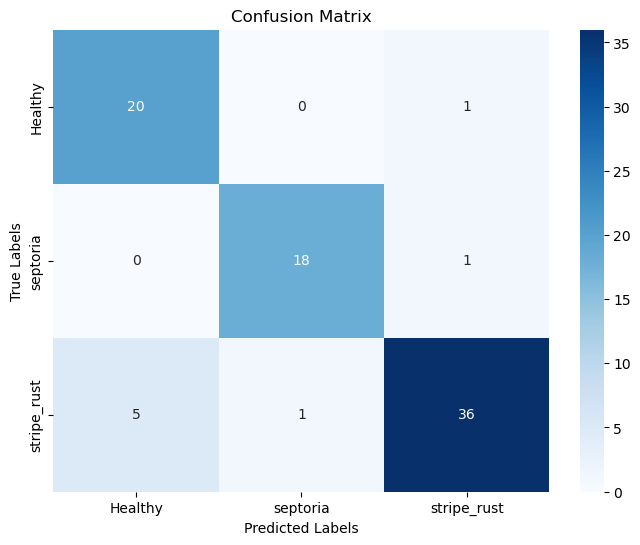


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.80      0.95      0.87        21
    septoria       0.95      0.95      0.95        19
 stripe_rust       0.95      0.86      0.90        42

    accuracy                           0.90        82
   macro avg       0.90      0.92      0.91        82
weighted avg       0.91      0.90      0.90        82



In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


_________________________________________________ DenseNet121 ______________________________________________

In [17]:
from tensorflow.keras.applications import DenseNet121
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=20
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.4346 - loss: 1.1114 - val_accuracy: 0.6049 - val_loss: 0.8633
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.6169 - loss: 0.8555 - val_accuracy: 0.7531 - val_loss: 0.6368
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7135 - loss: 0.6803 - val_accuracy: 0.7901 - val_loss: 0.5172
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8161 - loss: 0.5700 - val_accuracy: 0.8025 - val_loss: 0.4453
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8237 - loss: 0.5109 - val_accuracy: 0.8395 - val_loss: 0.3977
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8563 - loss: 0.4547 - val_accuracy: 0.8519 - val_loss: 0.3657
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8738 - loss: 0.4152 - val_accuracy: 0.8519 - val_loss: 0.3406
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8705 - loss: 0.3824 - val_accuracy: 0.8519 - val_loss

In [19]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)



3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9043 - loss: 0.2487
Test Loss: 0.23910222947597504
Test Accuracy: 0.9024389982223511
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step  WARNING:tensorflow:5 out of the last 250 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A3C109A3E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


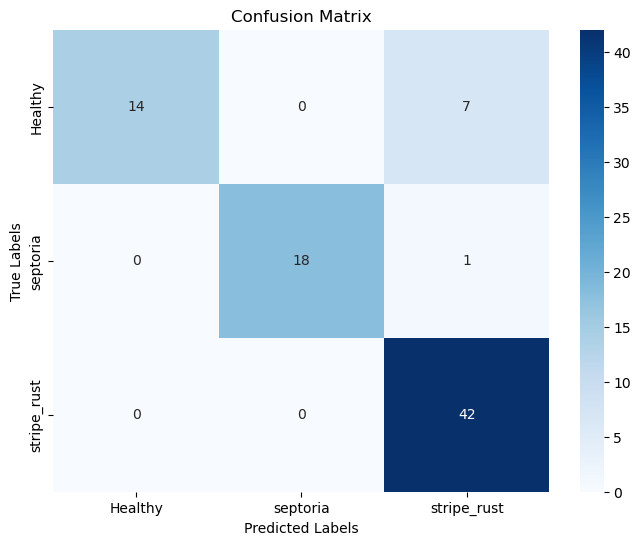


Classification Report:

              precision    recall  f1-score   support

     Healthy       1.00      0.67      0.80        21
    septoria       1.00      0.95      0.97        19
 stripe_rust       0.84      1.00      0.91        42

    accuracy                           0.90        82
   macro avg       0.95      0.87      0.90        82
weighted avg       0.92      0.90      0.90        82



In [20]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


_____________________________________________________ DenseNet169 _______________________________________________

In [21]:
from tensorflow.keras.applications import DenseNet169
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=10
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.5036 - loss: 0.9734 - val_accuracy: 0.7654 - val_loss: 0.6228
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7636 - loss: 0.6713 - val_accuracy: 0.7654 - val_loss: 0.4958
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8133 - loss: 0.4959 - val_accuracy: 0.8519 - val_loss: 0.3883
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8513 - loss: 0.4538 - val_accuracy: 0.9012 - val_loss: 0.3404
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8789 - loss: 0.4101 - val_accuracy: 0.8765 - val_loss: 0.3193
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8753 - loss: 0.3645 - val_accuracy: 0.9136 - val_loss: 0.2848
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9101 - loss: 0.3259 - val_accuracy: 0.8889 - val_loss: 0.2782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9152 - loss: 0.2960 - val_accuracy: 0.9259 - val_loss

In [23]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8509 - loss: 0.3617
Test Loss: 0.3402628004550934
Test Accuracy: 0.8658536672592163
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step


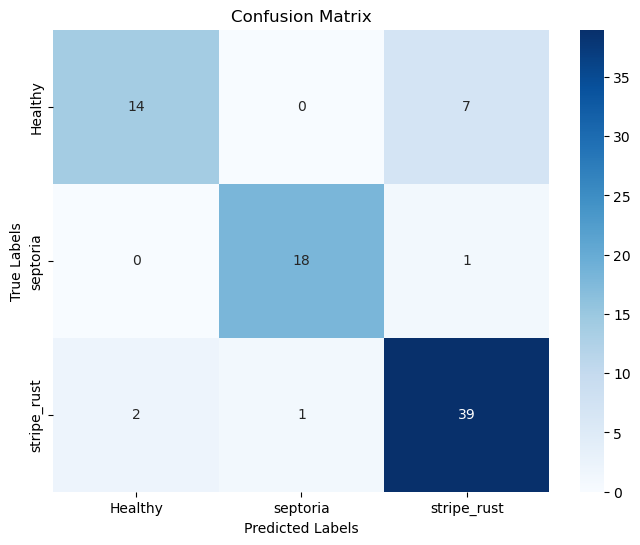


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.88      0.67      0.76        21
    septoria       0.95      0.95      0.95        19
 stripe_rust       0.83      0.93      0.88        42

    accuracy                           0.87        82
   macro avg       0.88      0.85      0.86        82
weighted avg       0.87      0.87      0.86        82



In [24]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


In [ ]:
_________________________________________________ ResNet50V2 _________________________________________________

In [25]:
from tensorflow.keras.applications import ResNet50V2
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=10
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4865 - loss: 1.0331 - val_accuracy: 0.7531 - val_loss: 0.4921
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8155 - loss: 0.4624 - val_accuracy: 0.8272 - val_loss: 0.3496
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8824 - loss: 0.3196 - val_accuracy: 0.8519 - val_loss: 0.3171
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9126 - loss: 0.2604 - val_accuracy: 0.9012 - val_loss: 0.2766
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9422 - loss: 0.2163 - val_accuracy: 0.8765 - val_loss: 0.2640
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9633 - loss: 0.1727 - val_accuracy: 0.9012 - val_loss: 0.2441
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9611 - loss: 0.1720 - val_accuracy: 0.8889 - val_loss: 0.2477
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9535 - loss: 0.1648 - val_accuracy: 0.9259 - val_loss:

In [27]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9244 - loss: 0.2533
Test Loss: 0.24006755650043488
Test Accuracy: 0.9268292784690857
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


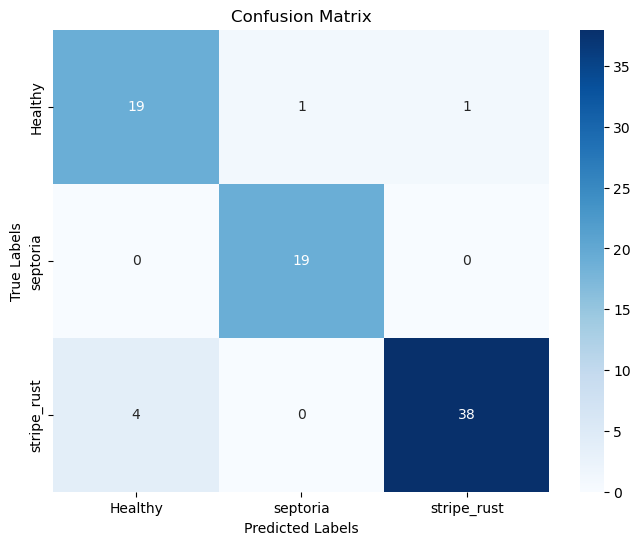


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.83      0.90      0.86        21
    septoria       0.95      1.00      0.97        19
 stripe_rust       0.97      0.90      0.94        42

    accuracy                           0.93        82
   macro avg       0.92      0.94      0.93        82
weighted avg       0.93      0.93      0.93        82



In [28]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


__________________________________________________ Xception ________________________________________________

In [29]:
from tensorflow.keras.applications import Xception
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [30]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=10
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.4999 - loss: 1.0116 - val_accuracy: 0.7531 - val_loss: 0.6332
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.7658 - loss: 0.6519 - val_accuracy: 0.8395 - val_loss: 0.4756
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8553 - loss: 0.4994 - val_accuracy: 0.8519 - val_loss: 0.4202
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8796 - loss: 0.4366 - val_accuracy: 0.8395 - val_loss: 0.3894
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8770 - loss: 0.4060 - val_accuracy: 0.8395 - val_loss: 0.3714
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8679 - loss: 0.3667 - val_accuracy: 0.8519 - val_loss: 0.3631
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9035 - loss: 0.3117 - val_accuracy: 0.8395 - val_loss: 0.3466
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9113 - loss: 0.3006 - val_accuracy: 0.8395 - val_loss:

In [31]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8287 - loss: 0.3604
Test Loss: 0.3533115088939667
Test Accuracy: 0.8292682766914368
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step


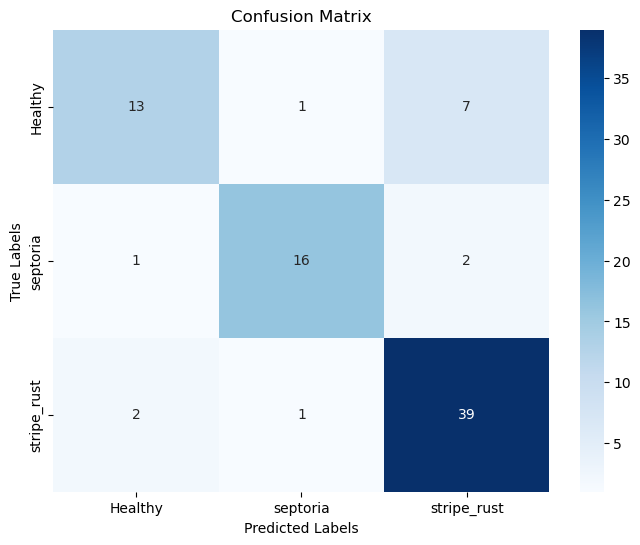


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.81      0.62      0.70        21
    septoria       0.89      0.84      0.86        19
 stripe_rust       0.81      0.93      0.87        42

    accuracy                           0.83        82
   macro avg       0.84      0.80      0.81        82
weighted avg       0.83      0.83      0.82        82



In [32]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


__________________________________________________________ ResNet152V2 _______________________________________________

In [12]:
from tensorflow.keras.applications import ResNet152V2
# -------------------------
# Part 4: MobileNetV2 Training
# -------------------------
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 547s 2us/step


In [13]:
history = model.fit(
    D_augmented_train, y_augmented_train,
    validation_data=(D_valid, y_valid),
    epochs=10
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 194s 11s/step - accuracy: 0.4448 - loss: 1.1502 - val_accuracy: 0.7407 - val_loss: 0.6528
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 161s 10s/step - accuracy: 0.6914 - loss: 0.6613 - val_accuracy: 0.7654 - val_loss: 0.4951
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 162s 10s/step - accuracy: 0.8382 - loss: 0.4483 - val_accuracy: 0.8272 - val_loss: 0.3930
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.8654 - loss: 0.4006 - val_accuracy: 0.8272 - val_loss: 0.3854
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 155s 10s/step - accuracy: 0.8900 - loss: 0.3126 - val_accuracy: 0.8519 - val_loss: 0.3327
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 197s 9s/step - accuracy: 0.9200 - loss: 0.2851 - val_accuracy: 0.8642 - val_loss: 0.3148
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.9311 - loss: 0.2574 - val_accuracy: 0.8642 - val_loss: 0.3035
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 152s 10s/step - accuracy: 0.9517 - loss: 0.2147 - val_accuracy: 0.864

In [14]:
# -------------------------
# Part 5: Testing and Evaluation
# -------------------------
test_loss, test_accuracy = model.evaluate(D_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(D_test)
y_pred_classes = np.argmax(y_pred, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 13s/step - accuracy: 0.9383 - loss: 0.2070
Test Loss: 0.19507652521133423
Test Accuracy: 0.9390243887901306
3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 14s/step


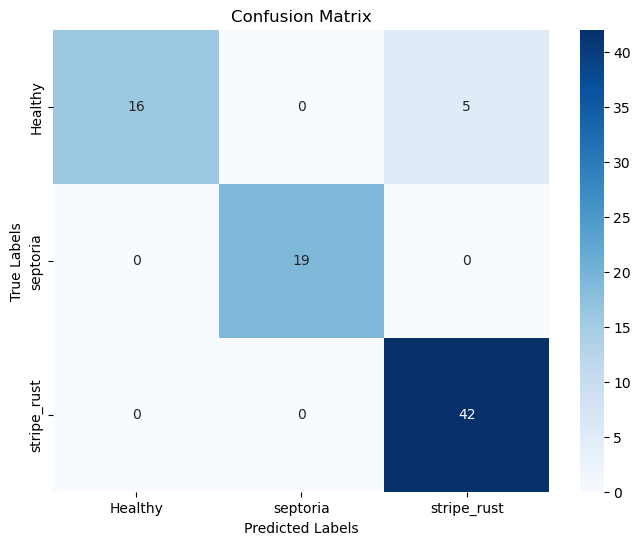


Classification Report:

              precision    recall  f1-score   support

     Healthy       1.00      0.76      0.86        21
    septoria       1.00      1.00      1.00        19
 stripe_rust       0.89      1.00      0.94        42

    accuracy                           0.94        82
   macro avg       0.96      0.92      0.94        82
weighted avg       0.95      0.94      0.94        82



In [15]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))
